#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---
## Homework 3b - Extension of lab. 07 (Reinforcement Learning)
### Student: Federico Michelotto - 1218322

Main reference: [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

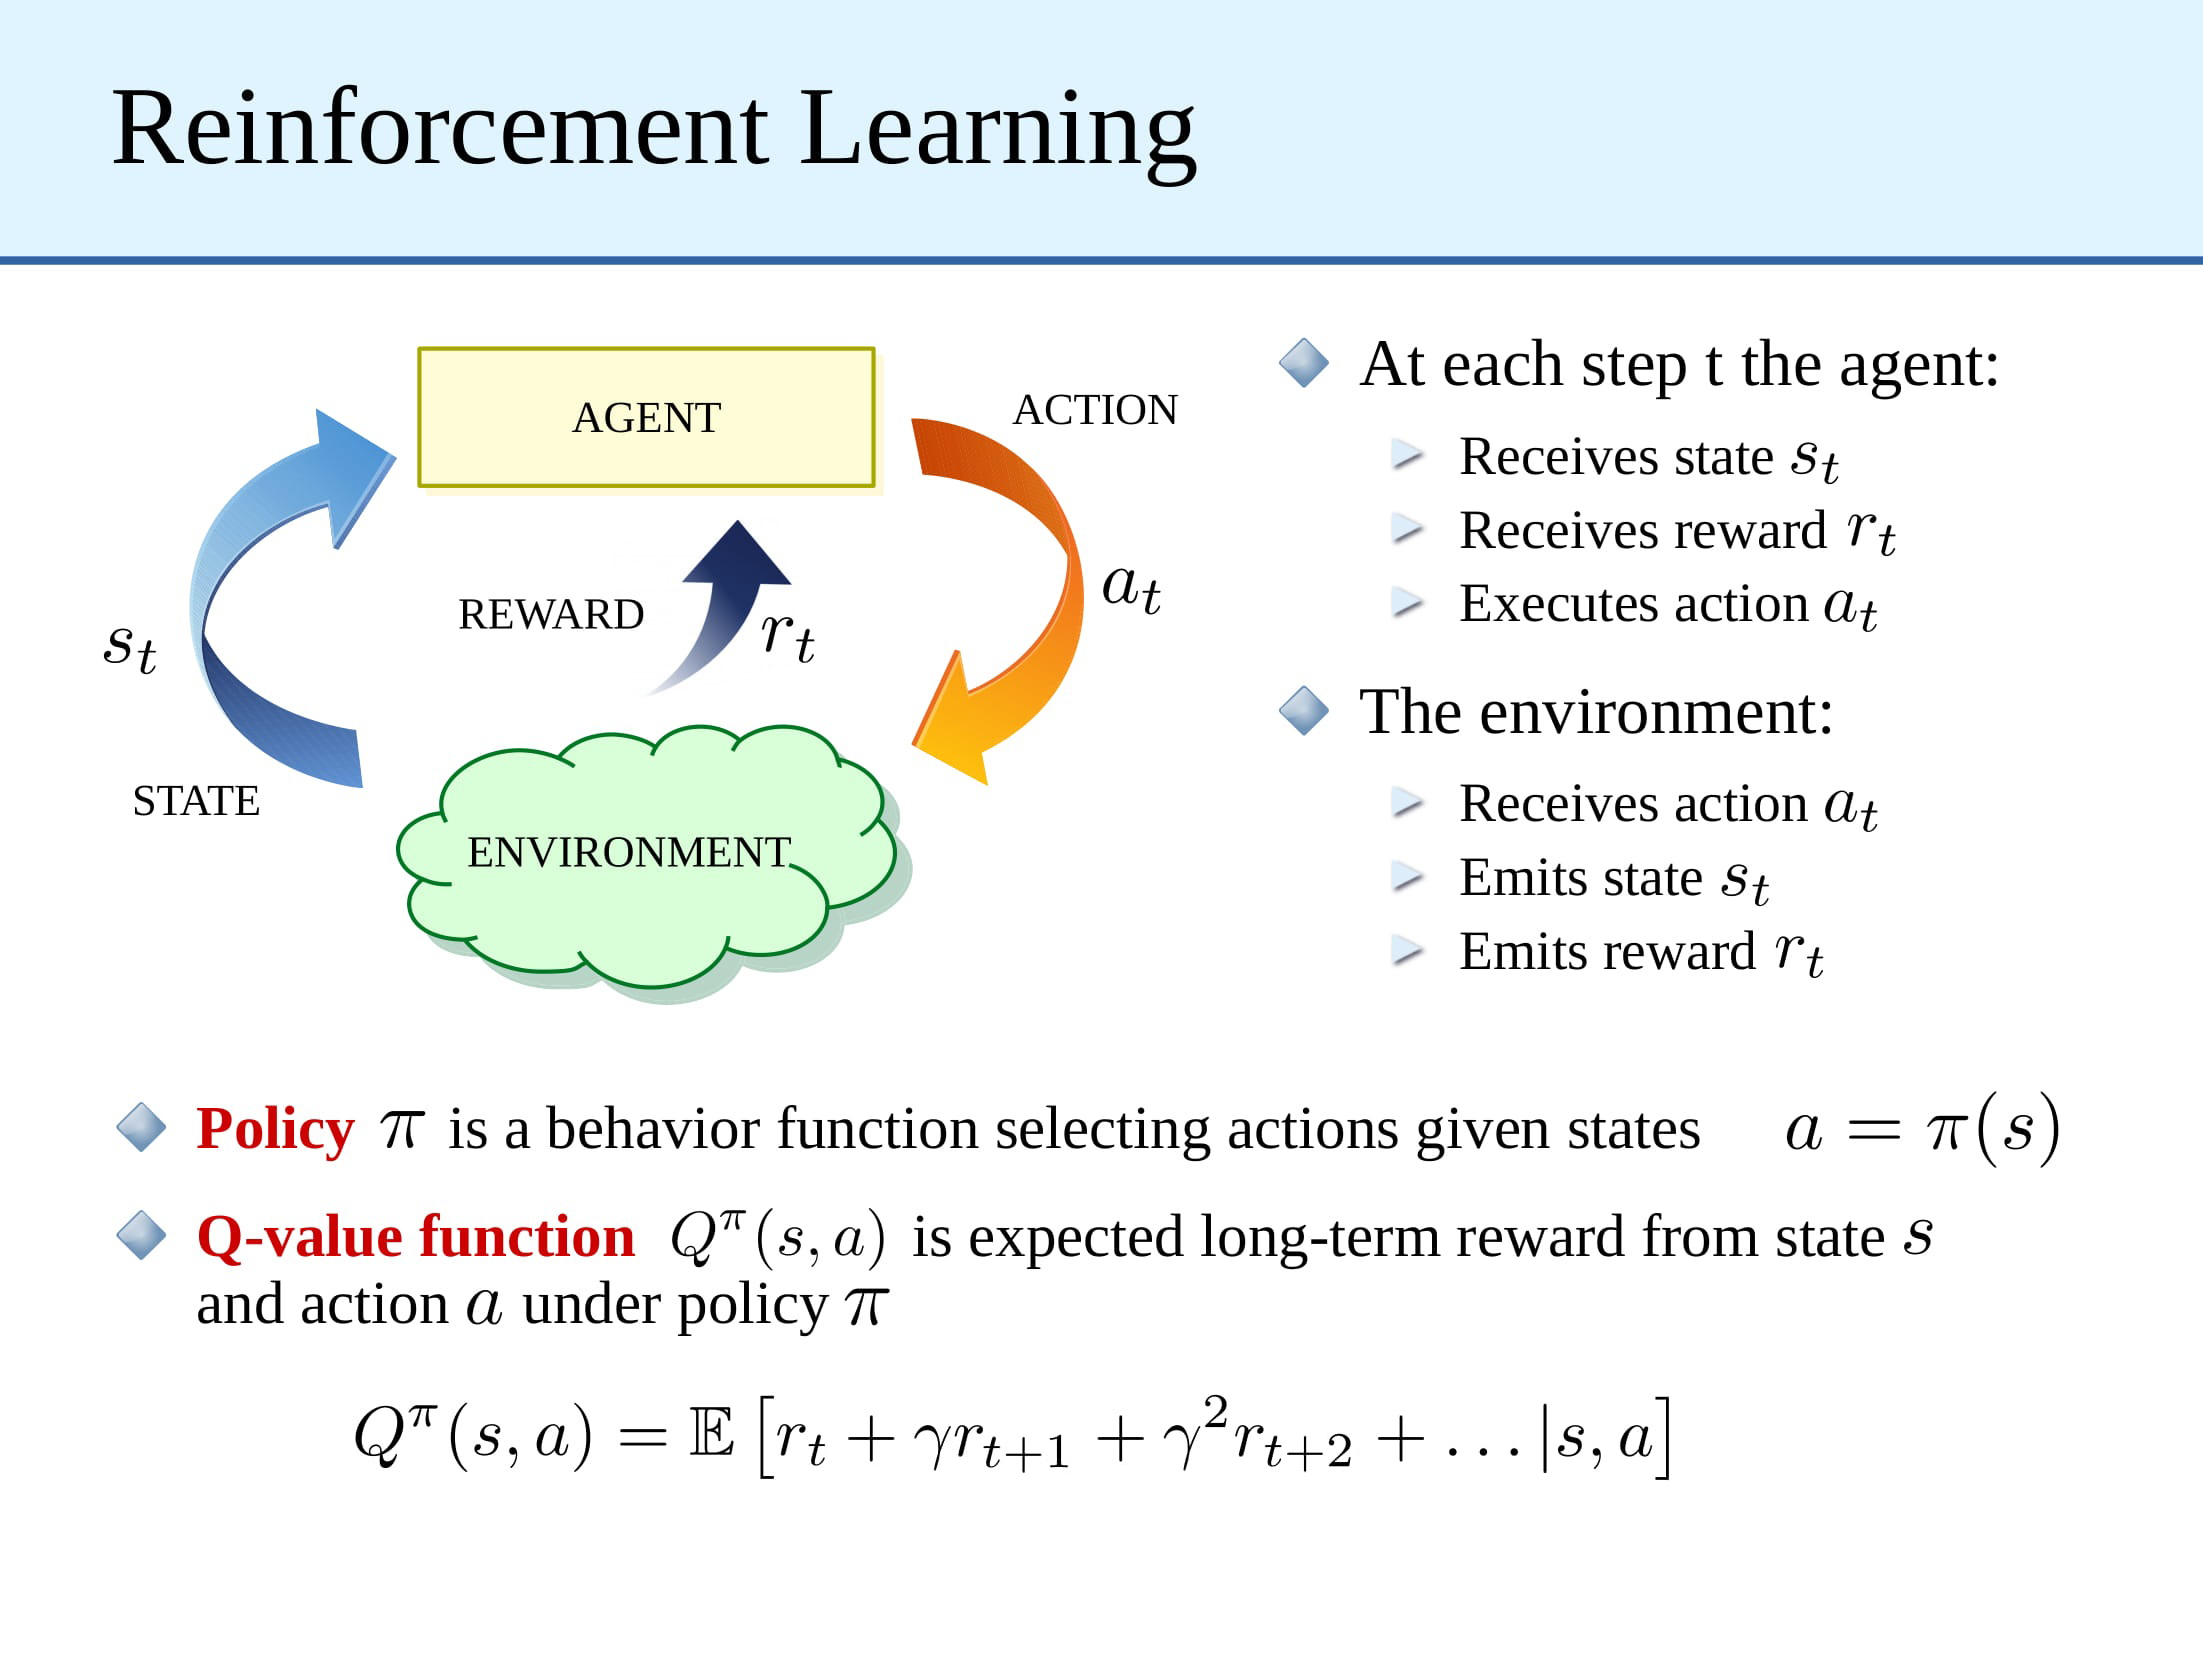

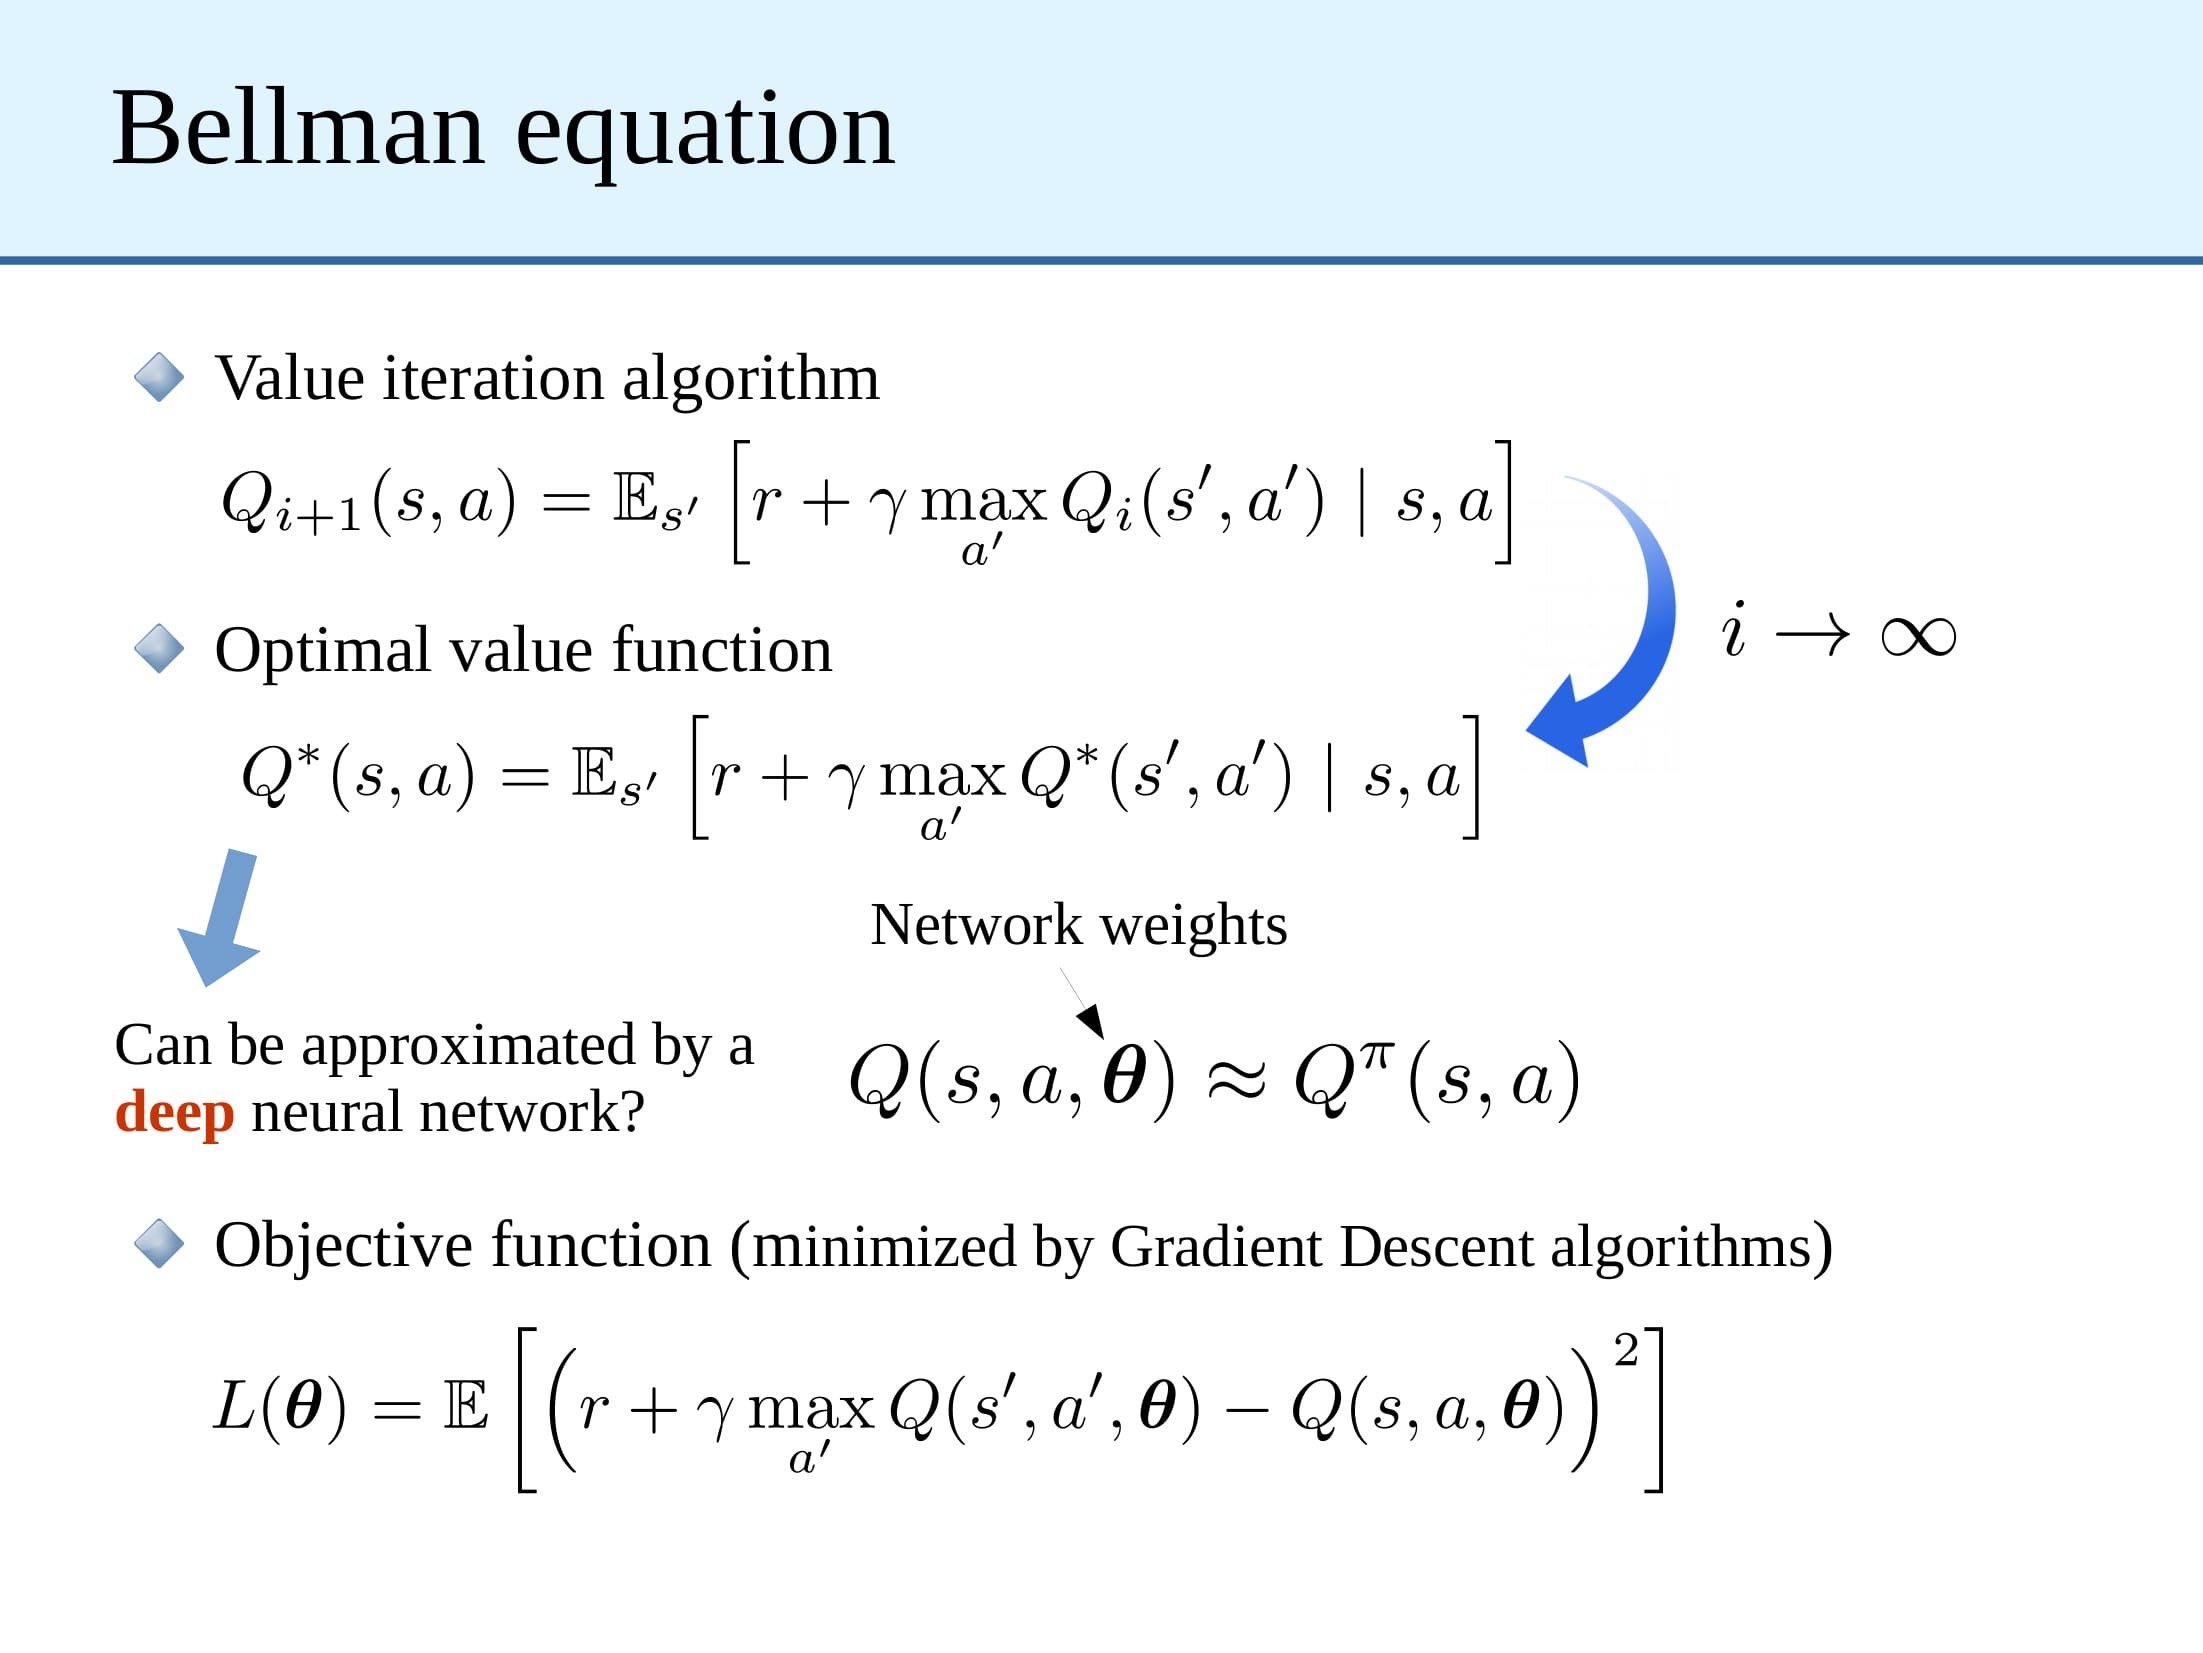

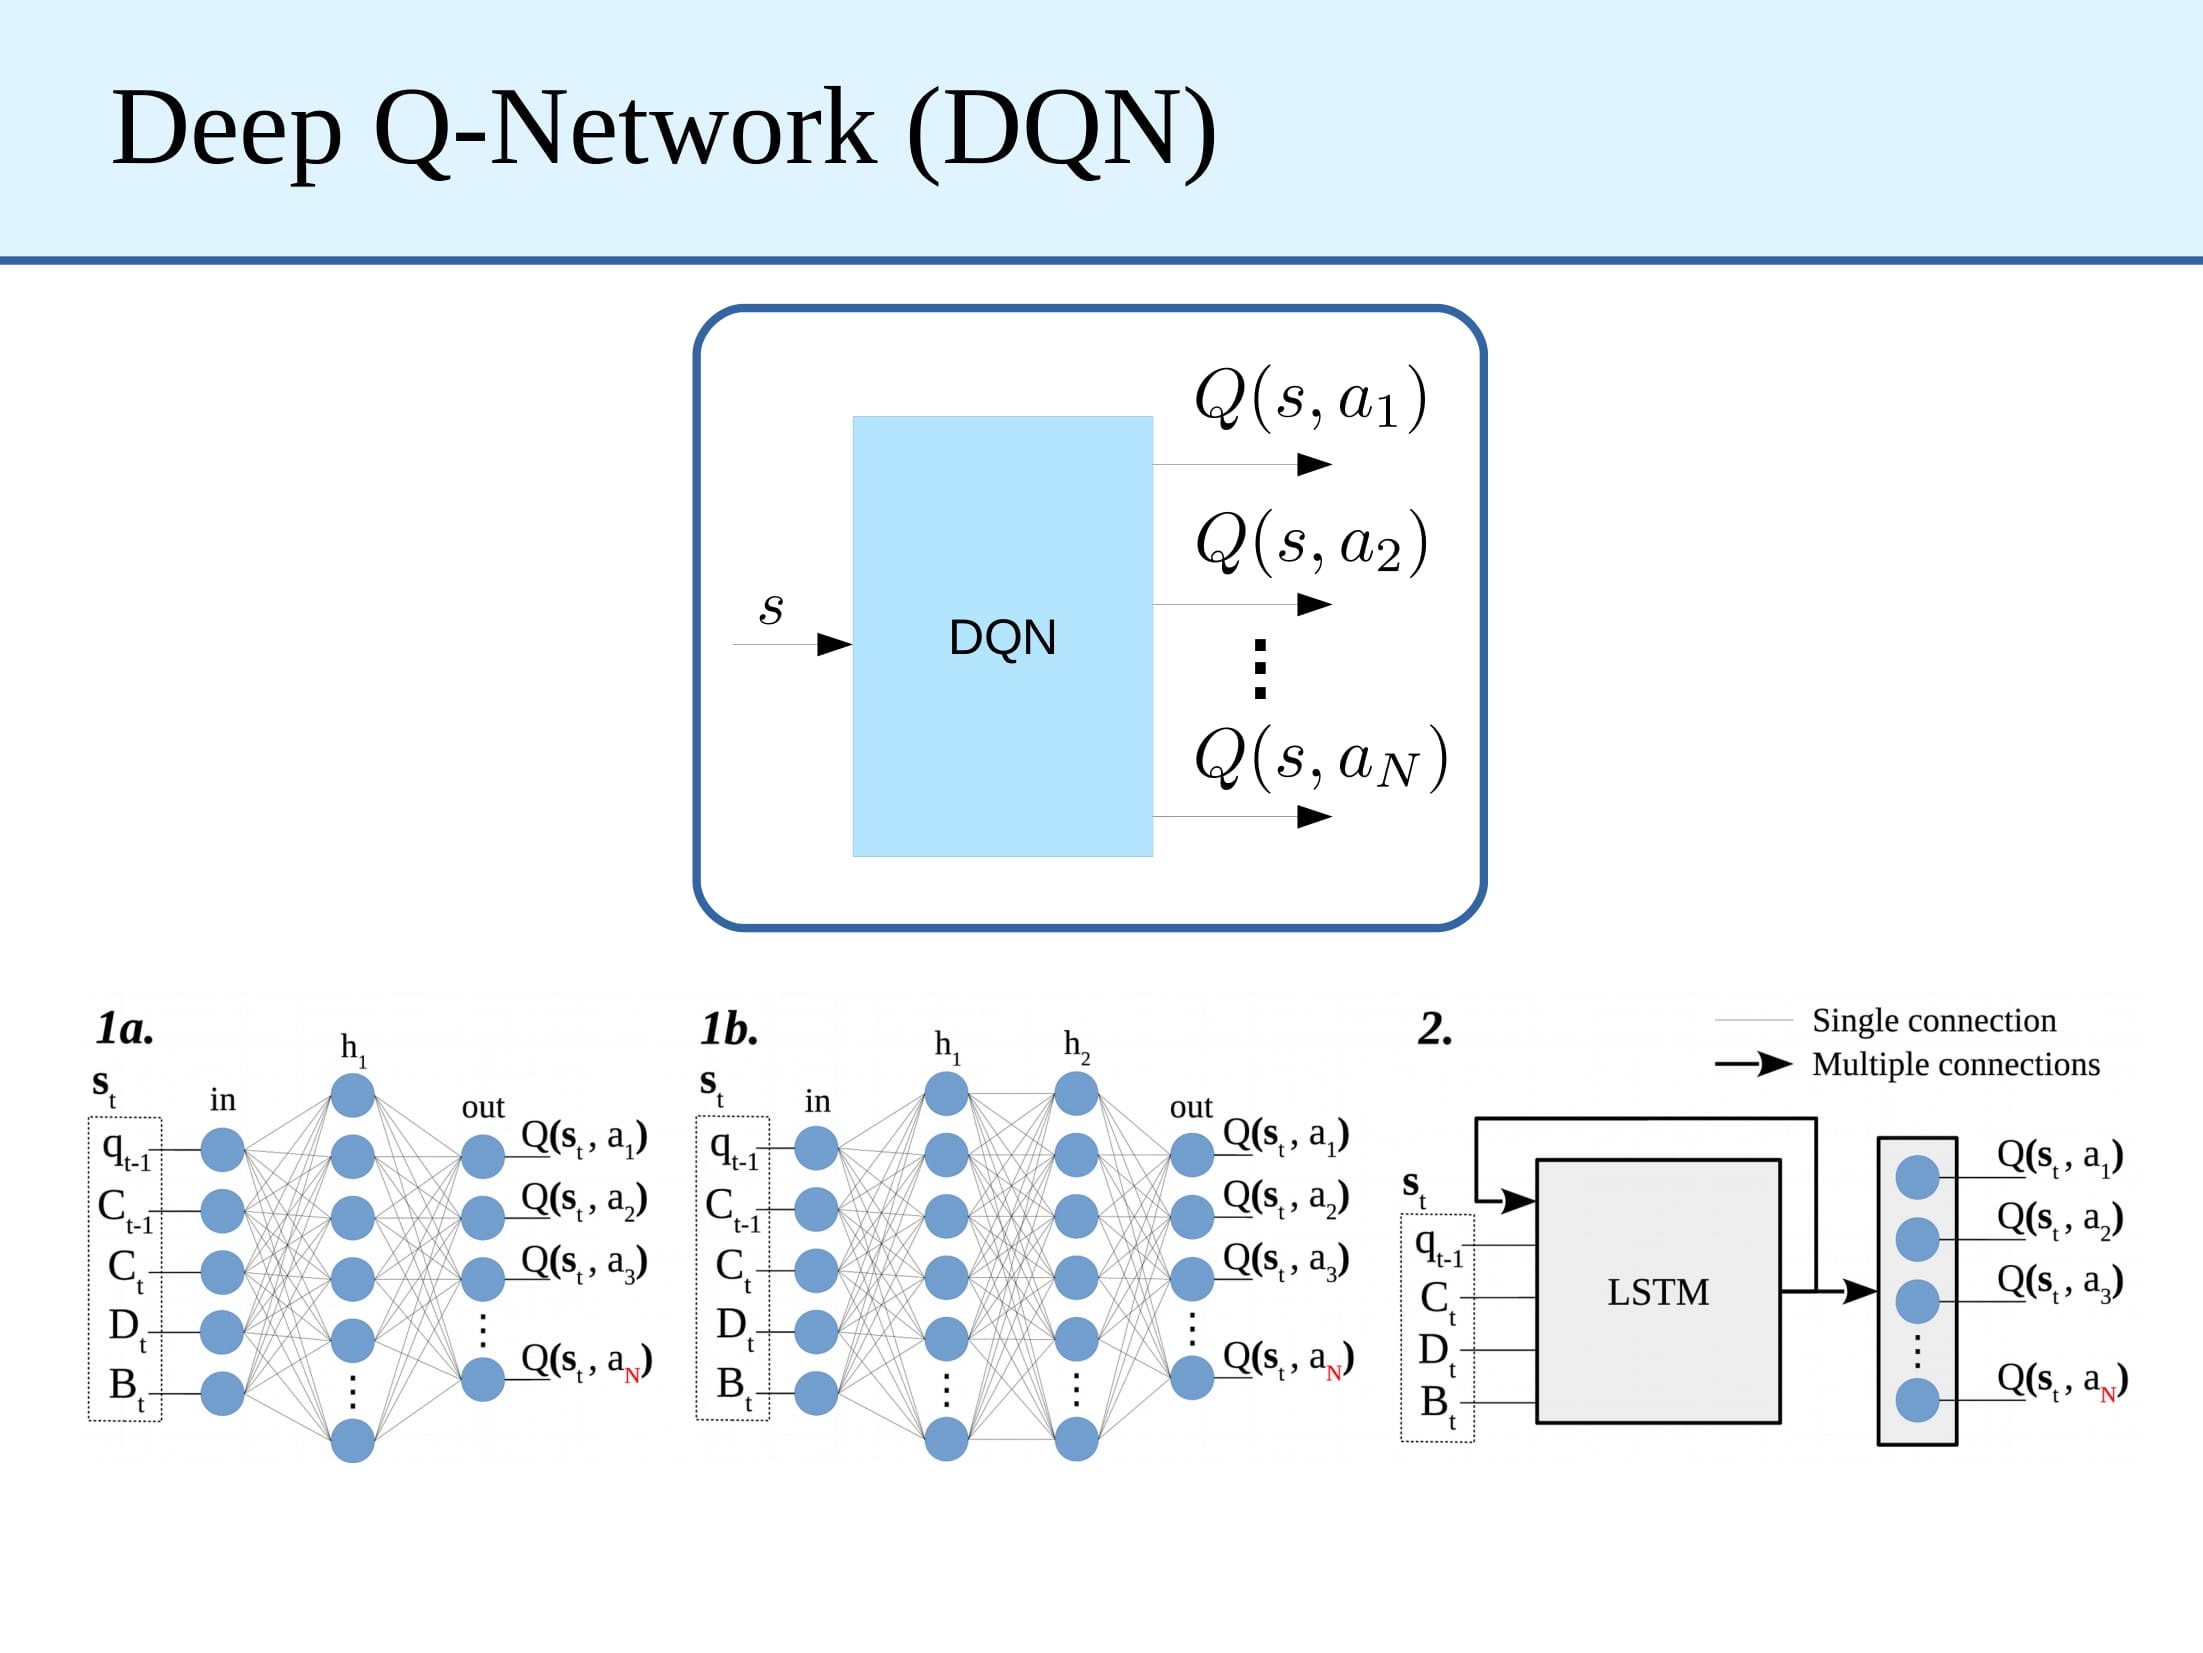

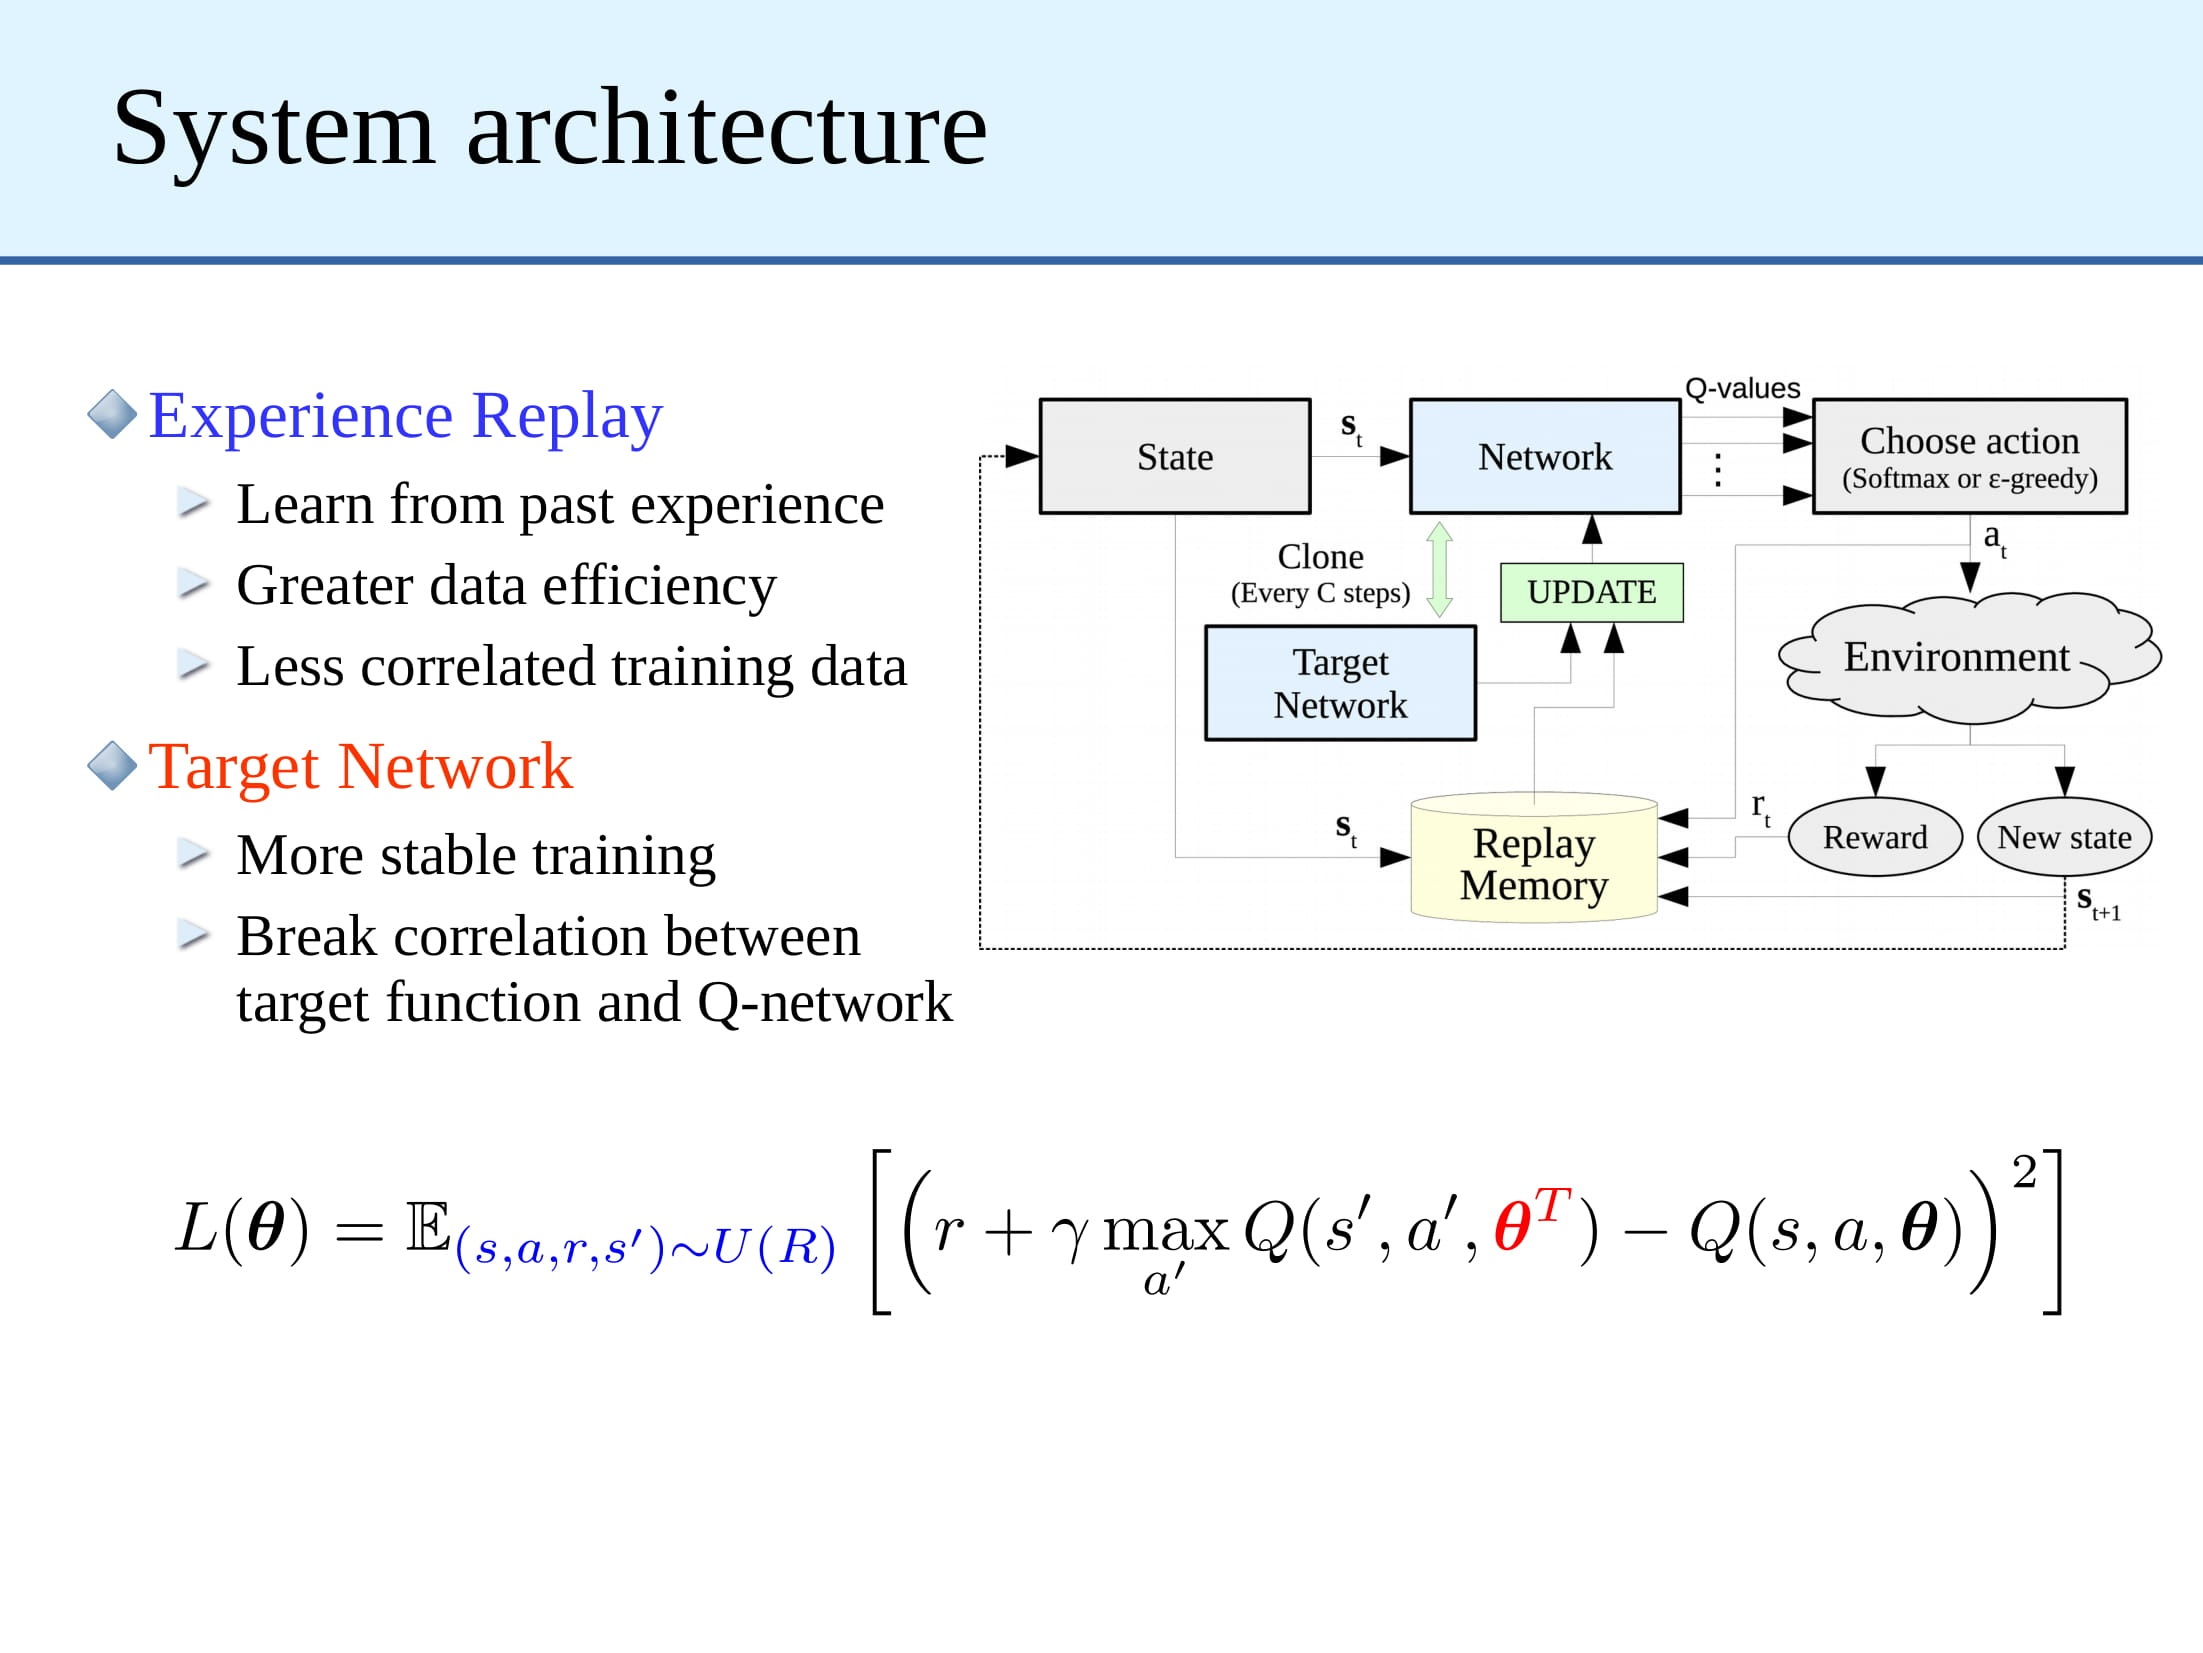

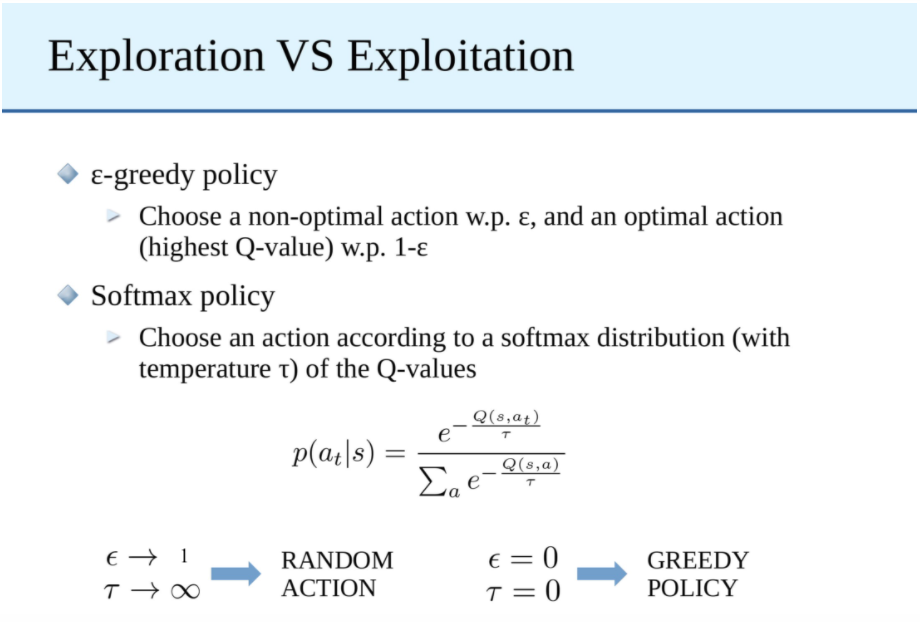

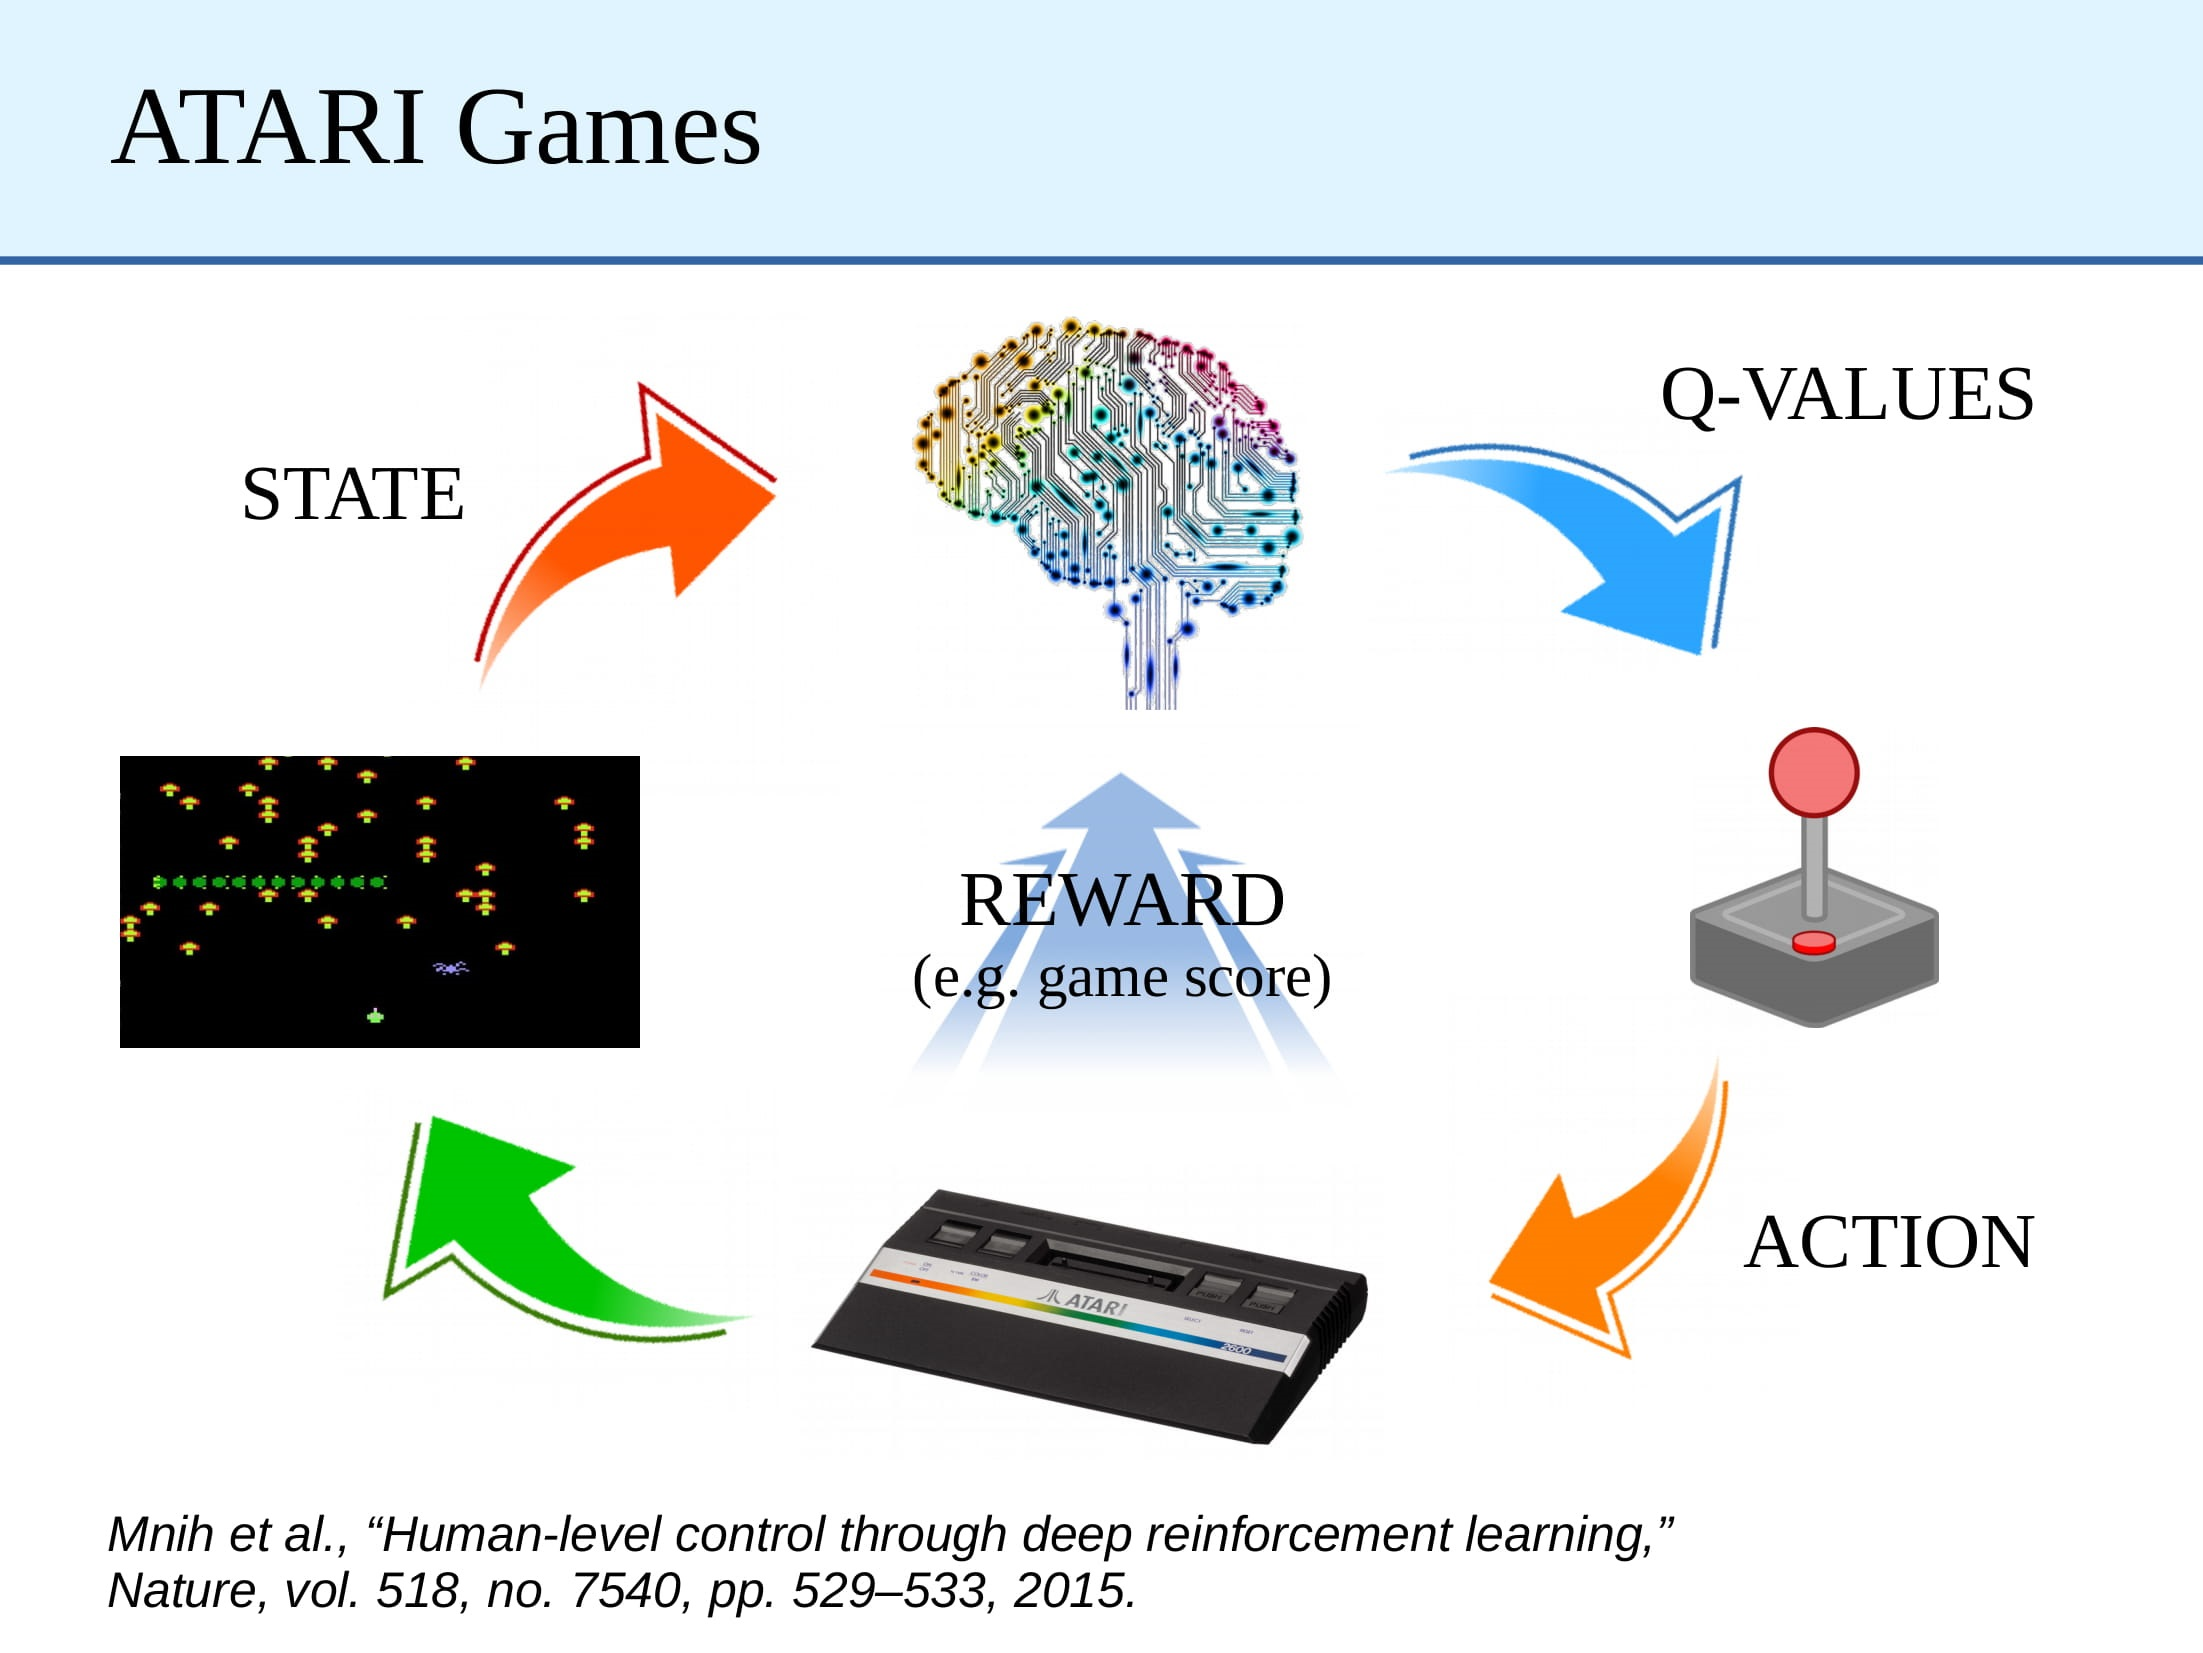

In [1]:
#!pip install gym

In [2]:
import random
import torch
import torchvision
import numpy as np
import gym
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from torchvision import transforms
from PIL import Image
from skimage.color import rgb2gray

from collections import namedtuple, deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [3]:
# !apt update
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install piglet

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [7]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(0)

In [8]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [9]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
#if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
#    !bash ../xvfb start
#    %env DISPLAY=:1

In [10]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
    mp4list = glob.glob('video/*.mp4')
    mp4list.sort()
    for mp4 in mp4list:
        print(f"\nSHOWING VIDEO {mp4}")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))

def wrap_env(env, video_callable=None):
    env = Monitor(env, './video', force=True, video_callable=video_callable)
    return env

# Experience replay (Replay Memory)

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html). 

In [11]:
# define tuple structure
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append(Transition(state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [12]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
    print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([Transition(state=3, action=3, next_state=3, reward=3), Transition(state=4, action=4, next_state=4, reward=4), Transition(state=5, action=5, next_state=5, reward=5)], maxlen=3)

RANDOM SAMPLING
[Transition(state=4, action=4, next_state=4, reward=4), Transition(state=3, action=3, next_state=3, reward=3)]
[Transition(state=3, action=3, next_state=3, reward=3), Transition(state=5, action=5, next_state=5, reward=5)]
[Transition(state=3, action=3, next_state=3, reward=3), Transition(state=4, action=4, next_state=4, reward=4)]
[Transition(state=3, action=3, next_state=3, reward=3), Transition(state=4, action=4, next_state=4, reward=4)]
[Transition(state=4, action=4, next_state=4, reward=4), Transition(state=3, action=3, next_state=3, reward=3)]


In [13]:
batch = replay_mem.sample(3)
print(batch)

[Transition(state=5, action=5, next_state=5, reward=5), Transition(state=3, action=3, next_state=3, reward=3), Transition(state=4, action=4, next_state=4, reward=4)]


Transpose the table:

In [14]:
batch_T = Transition(*zip(*batch))

Retrieve all the rewards in the batch

In [15]:
batch_T.reward

(5, 3, 4)

# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Below is defined a convolutional neural network that takes in input grayscales images with size [screen_height, screen_width].

I have tried several different configurations, but actually, the only configuration for which I was able to obtain some result, consists of a convolutional layer with 16 channels and kernels of size 9 and stride 3, followed by a flatten layer and fully connected layer.

## Network definition

In [16]:
# Function to compute the output dimension of a conv. layer that receives an input with dimension size
def conv_size_out(size, kernel_size = 8, stride = 4, padding = 0):
    return math.ceil((size + 2*padding - (kernel_size - 1)) / stride)

In [17]:
class DQN(nn.Module):
    
    def __init__(self, screen_height, screen_width, n_actions):
        super().__init__()
        
        ### Convolutional section
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, 
                      stride=4, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, 
                      stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        conv_w = conv_size_out(conv_size_out(screen_height), kernel_size=4, stride=2)
        conv_h = conv_size_out(conv_size_out(screen_width), kernel_size=4, stride=2)
        linear_input_size = conv_w * conv_h * 32
        ### Linear section
        self.lin_layers = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=linear_input_size, out_features=256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            # Second linear layer
            nn.Linear(in_features=256, out_features=n_actions),
        )
    

    def forward(self, x):
        # Apply convolutions
        x = self.conv_layers(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.lin_layers(x)
        return x

In [18]:
# Define an example network
net = DQN(screen_height=20, screen_width=75, n_actions = 2).to(device)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

NOTE: there is a difference wrt paper in that they do not exclude the best action when chosing the action at random

In [19]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out

In [20]:
# Test if it works as expected
state = torch.rand(4, 20, 75, dtype=torch.float32).unsqueeze(0).to(device)
print(state.shape)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

torch.Size([1, 4, 20, 75])
ACTION: 1
Q-VALUES: tensor([[-0.0192,  0.0185]], device='cuda:0')


### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [21]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        net_out = net(state)
    # delete the 0 (void) dimension in order to have a 1-D array (required by np.random.choice)
    net_out = net_out.squeeze()
    
    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).cpu().numpy()  
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out

In [22]:
state = torch.rand(4, 20, 75, dtype=torch.float32).unsqueeze(0).to(device)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: tensor([0.0036, 0.0269], device='cuda:0')


### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

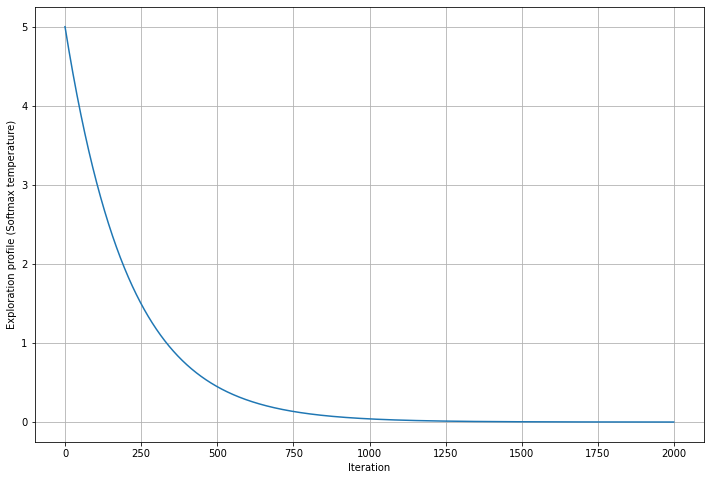

In [23]:
### Define exploration profile
initial_value = 5
num_iterations = 2000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Get screen

Below I defined the function get_screen() that returns the current frame of the game.
The frame returned is resized to (40,60) and centered with respect to the cart.
The function get_cart_location() returns the position of the cart by looking for the leftmost and rightmost black pixel at a certain row, that correspond to the sides of the cart.

In [24]:
resize = transforms.Compose([transforms.ToPILImage(),
                    transforms.Resize(20, interpolation=Image.CUBIC),
                    transforms.ToTensor()])

# ToTensor() brings the values to [0.0,1.0]


## return the cart location in a frame with a width equal to screen_width
# def get_cart_location(screen_width):
#     world_width = env.x_threshold * 2  # (x_max - x_min) = 2*x_max of the cart with respect to the center (in units)
#     scale = screen_width / world_width # pixels per unit
#     return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_cart_location(screen): 
    screen_height, screen_width = screen.shape
    ref_h = int(screen_height*0.95 )
    left = 0
    right = screen_width-1
    for x in range(screen_width):
        if screen[ref_h][x] < 0.1:
            left = x
            break
    for x in range(screen_width):
        if screen[ref_h][screen_width-1-x] < 0.1:
            right = x
            break
    return int( (left+right)/2 )

def get_screen():
    # Returned screen requested by gym is 400x600x3
    screen = env.render(mode='rgb_array') #(Y,X,Z)
    screen_height, screen_width, _ = screen.shape
    # Convert to grayscale (values range is now [0.0, 1.0]) 
    screen = rgb2gray(screen) # (Y,X)
    # Cart is in the lower half, so strip off the top and bottom of the screen
    screen = screen[int(screen_height*0.4):int(screen_height * 0.8), :]
    # 400x600 -> 160x600

    # # get the cart location in the screen
    # cart_location = get_cart_location(screen)
    # # define the desired screen width
    # view_width = int(screen_width * 0.4) # 240
    # # Select the region in which the cart is located
    # # //: floor division
    # # slice() to create a mask
    # if cart_location < view_width // 2: 
    #     # [0,120)
    #     # select the firsts view_width pixels
    #     slice_range = slice(view_width)
    # elif cart_location > (screen_width - view_width // 2): 
    #     # (480,600]
    #     slice_range = slice(-view_width, None)
    #     # select the lasts view_width pixels
    # else: 
    #     # [120,480]
    #     # select view_width pixels such that the cart is at the center
    #     slice_range = slice(cart_location - view_width // 2,
    #                         cart_location + view_width // 2)
    # # Apply the mask
    # screen = screen[:, slice_range]
    # # 160x600 -> 160x240

    # Invert color intensity
    screen = 1.0 - np.ascontiguousarray(screen, dtype=np.float32)
    # Convert to tensor
    screen = torch.from_numpy(screen) # (1, Y, X)
    # Resize 
    return resize(screen)

/home/federico/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

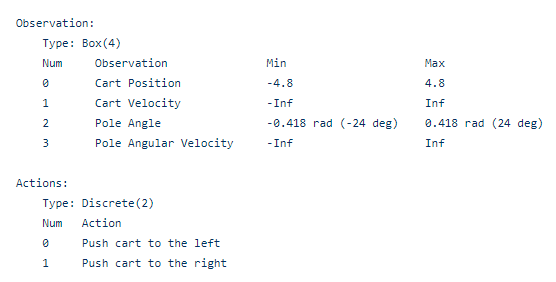

In [25]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
env.reset()

# Get the shapes of the state space (observation_space) and action space (action_space)
screen = env.render(mode='rgb_array').transpose((2, 0, 1))
_, screen_height, screen_width = screen.shape
action_space_dim = env.action_space.n

print(f"SCREEN SIZE: {screen.shape}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

SCREEN SIZE: (3, 400, 600)
ACTION SPACE SIZE: 2


## Example

In this example are shown two successive frames, and their difference (negative values are set to 0).

The difference between two consecutive frames will be used to represent the state of the environment.

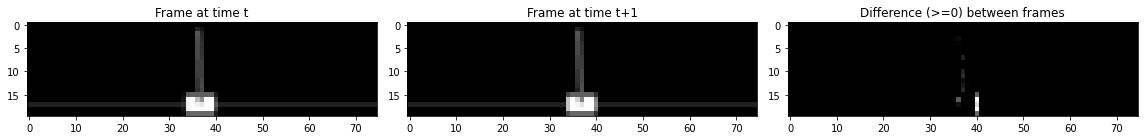

In [26]:
env.reset()
env.step(0)
env.step(0)
env.step(1)
env.step(1)
env.step(0)
env.step(1)
env.step(1)
env.step(1)
env.step(0)
env.step(1)
env.step(1)
env.step(0)

screen0 = get_screen()
env.step(1)
screen1 = get_screen()

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(screen0.squeeze().cpu().numpy(), interpolation='none', cmap=plt.cm.gray)
ax[0].set_title("Frame at time t")
ax[1].imshow(screen1.squeeze().cpu().numpy(), interpolation='none', cmap=plt.cm.gray)
ax[1].set_title("Frame at time t+1")
screen = screen1-screen0
screen[screen < 0] = 0
ax[2].imshow(screen.squeeze().cpu().numpy(), interpolation='none', cmap=plt.cm.gray)
ax[2].set_title("Difference (>=0) between frames")

fig.tight_layout()
plt.show()


In [27]:
get_screen().shape

torch.Size([1, 20, 75])

In [28]:
env.close()

# Network update

In [29]:
# define tuple structure
Frame = namedtuple('Transition',
                        ('frame'))

class StateMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, frame):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append(frame)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Initialization

In [30]:
# Define the replay memory
state_mem = StateMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(state_mem)}")
state_mem.push(torch.rand(1,3,40,75))
state_mem.push(torch.rand(1,3,40,75))
print(f"CURRENT MEMORY SIZE: {len(state_mem)}")
print(torch.cat(list(state_mem.memory)).shape)


CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 2
torch.Size([2, 3, 40, 75])


In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [31]:
### PARAMETERS
gamma = 0.999   # gamma parameter for the long term reward
replay_memory_capacity = 1000000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 4   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
window_size = 4 # number of frames that define a state

In [32]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)  

### Initialize the state memory
state_mem = StateMemory(capacity=4)

### Initialize the policy network
policy_net = DQN(20, 75, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(20, 75, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [33]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    batch_T = Transition(*zip(*batch))

    # Create tensors for each element of the batch
    states      = torch.cat(batch_T.state).to(device)
    actions     = torch.tensor(batch_T.action, dtype=torch.int64).to(device)
    rewards     = torch.tensor(batch_T.reward, dtype=torch.float32).to(device)
    
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.cat([s for s in batch_T.next_state if s is not None]).to(device) # the next state can be None if the game has ended
    non_final_mask        = torch.tensor(np.array([s is not None for s in batch_T.next_state]), dtype=torch.bool).to(device)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()
    return loss

## Training loop

In [34]:
# Initialize the Gym environment
env = gym.make('CartPole-v1')
env.seed(0) # Set a random seed for the environment (reproducible results)

[0]

In [35]:
# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100000 == 0) # Save a video every 100 episodes
scores = []

for annealing_step in range(2):
    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        env.reset()
        current_screen = get_screen().to(device)
        for i in range(window_size):
            state_mem.push(current_screen)
        state = torch.cat(list(state_mem.memory)).unsqueeze(0)

        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        loss = 0

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            seq_reward = 0 # reward for the current sequence

            for i in range(window_size):
                _, reward, done, _ = env.step(action)
                score += 1
                seq_reward += reward
                if done:
                    break

            current_screen = get_screen().to(device)
            state_mem.push(current_screen)
            next_state = torch.cat(list(state_mem.memory)).unsqueeze(0)

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty 
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, seq_reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            print('Updating target network... (loss = %f)' % loss)
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        scores.append(score)

  0%|          | 0/2000 [00:00<?, ?it/s]

Updating target network... (loss = 0.000000)
EPISODE: 1 - FINAL SCORE: 10 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 16 - Temperature: 4.975916619159958
EPISODE: 3 - FINAL SCORE: 13 - Temperature: 4.951949240166453
EPISODE: 4 - FINAL SCORE: 11 - Temperature: 4.928097304276156
EPISODE: 5 - FINAL SCORE: 11 - Temperature: 4.904360255437022
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 4.880737540275332
EPISODE: 7 - FINAL SCORE: 18 - Temperature: 4.857228608082783
EPISODE: 8 - FINAL SCORE: 30 - Temperature: 4.833832910803663
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 4.81054990302206
EPISODE: 10 - FINAL SCORE: 51 - Temperature: 4.787379041949158
Updating target network... (loss = 0.000000)
EPISODE: 11 - FINAL SCORE: 27 - Temperature: 4.764319787410579
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 4.741371601833787
EPISODE: 13 - FINAL SCORE: 17 - Temperature: 4.718533950235563
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 4.695806300209525
EPISODE: 15 - FINAL SCORE: 16 - Temperature: 4.6731881

  0%|          | 0/2000 [00:00<?, ?it/s]

Updating target network... (loss = 11.035228)
EPISODE: 1 - FINAL SCORE: 152 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 139 - Temperature: 4.975916619159958
EPISODE: 3 - FINAL SCORE: 108 - Temperature: 4.951949240166453
EPISODE: 4 - FINAL SCORE: 444 - Temperature: 4.928097304276156
EPISODE: 5 - FINAL SCORE: 239 - Temperature: 4.904360255437022
EPISODE: 6 - FINAL SCORE: 67 - Temperature: 4.880737540275332
EPISODE: 7 - FINAL SCORE: 115 - Temperature: 4.857228608082783
EPISODE: 8 - FINAL SCORE: 115 - Temperature: 4.833832910803663
EPISODE: 9 - FINAL SCORE: 490 - Temperature: 4.81054990302206
EPISODE: 10 - FINAL SCORE: 217 - Temperature: 4.787379041949158
Updating target network... (loss = 9.509573)
EPISODE: 11 - FINAL SCORE: 356 - Temperature: 4.764319787410579
EPISODE: 12 - FINAL SCORE: 260 - Temperature: 4.741371601833787
EPISODE: 13 - FINAL SCORE: 348 - Temperature: 4.718533950235563
EPISODE: 14 - FINAL SCORE: 103 - Temperature: 4.695806300209525
EPISODE: 15 - FINAL SCORE: 235 - Tempe

In [36]:
env.close()

In [38]:
torch.save(policy_net.state_dict(), "policy_net_hw3b_post.pt")
torch.save(target_net.state_dict(), "target_net_hw3b_post.pt")

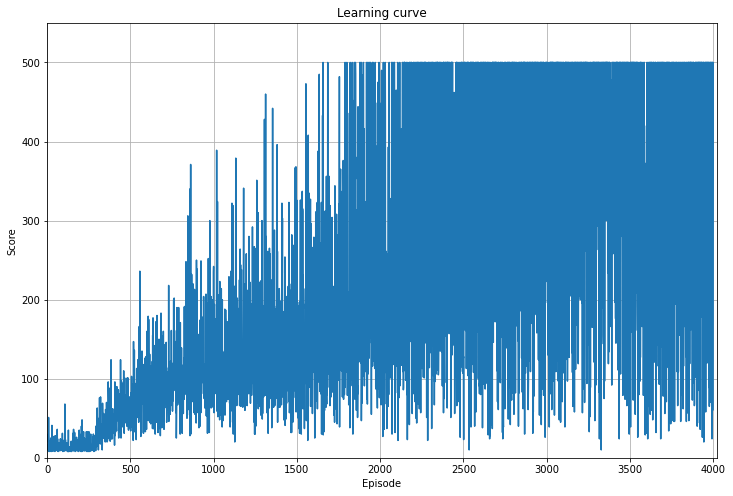

In [37]:
fig = plt.figure(figsize=(12,8))
plt.plot(range(len(scores)), scores)
plt.title('Learning curve')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.ylim(0, 550)
plt.xlim(0, len(scores)+20)
plt.grid()
plt.show()

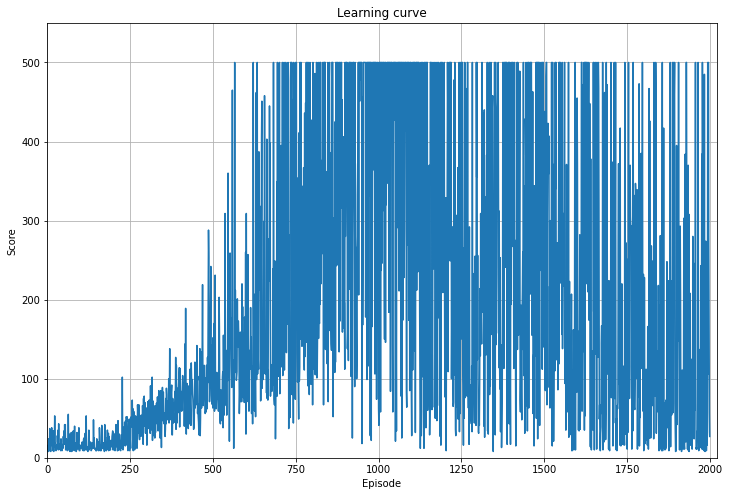

In [78]:
# # ### PARAMETERS
# # gamma = 0.999   # gamma parameter for the long term reward
# # replay_memory_capacity = 100000   # Replay memory capacity
# # lr = 1e-3   # Optimizer learning rate
# # target_net_update_steps = 10   # Number of episodes to wait before updating the target network
# # batch_size = 128   # Number of samples to take from the replay memory for each update
# # bad_state_penalty = 3   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
# # min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
# # 3 steps

# fig = plt.figure(figsize=(12,8))
# plt.plot(range(len(scores)), scores)
# plt.title('Learning curve')
# plt.xlabel('Episode')
# plt.ylabel('Score')
# plt.ylim(0, 550)
# plt.xlim(0, len(scores)+20)
# plt.grid()
# plt.show()

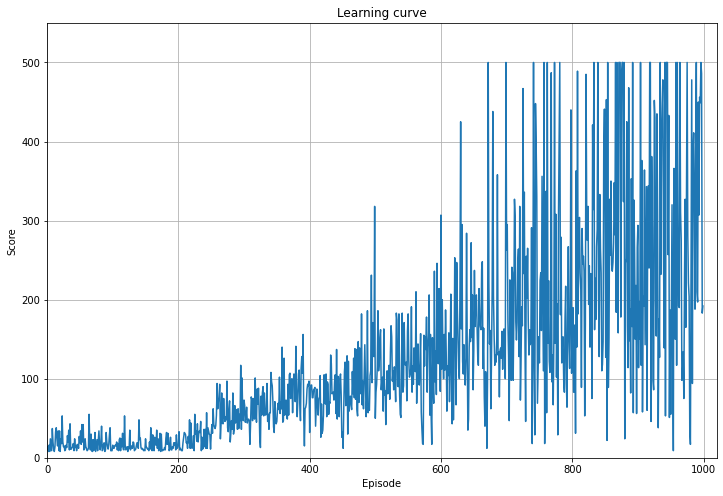

In [37]:
# # ### PARAMETERS
# # gamma = 0.999   # gamma parameter for the long term reward
# # replay_memory_capacity = 1000000   # Replay memory capacity
# # lr = 1e-3   # Optimizer learning rate
# # target_net_update_steps = 10   # Number of episodes to wait before updating the target network
# # batch_size = 128   # Number of samples to take from the replay memory for each update
# # bad_state_penalty = 3   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
# # min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

# fig = plt.figure(figsize=(12,8))
# plt.plot(range(len(scores)), scores)
# plt.title('Learning curve')
# plt.xlabel('Episode')
# plt.ylabel('Score')
# plt.ylim(0, 550)
# plt.xlim(0, len(scores)+20)
# plt.grid()
# plt.show()

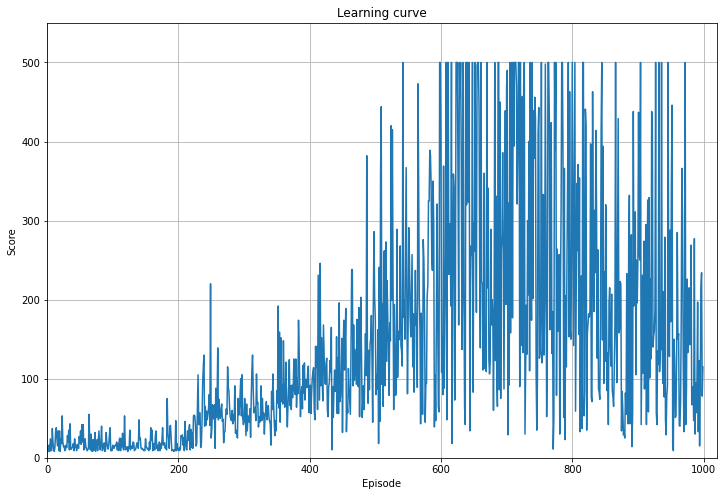

In [ ]:
# # ### PARAMETERS
# # gamma = 0.99   # gamma parameter for the long term reward
# # replay_memory_capacity = 100000   # Replay memory capacity
# # lr = 1e-2   # Optimizer learning rate
# # target_net_update_steps = 10   # Number of episodes to wait before updating the target network
# # batch_size = 128   # Number of samples to take from the replay memory for each update
# # bad_state_penalty = 3   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
# # min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

# fig = plt.figure(figsize=(12,8))
# plt.plot(range(len(scores)), scores)
# plt.title('Learning curve')
# plt.xlabel('Episode')
# plt.ylabel('Score')
# plt.ylim(0, 550)
# plt.xlim(0, len(scores)+20)
# plt.grid()
# plt.show()

From the learning curve we can observe that the agent was able to reach the 100 steps barrier in many occasions, but with this configuration the agent was not able to learn how to solve the game successfully. 

# Final test

In [39]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    
    # Reset the environment and get the initial state
    env.reset()
    current_screen = get_screen().to(device)
    for i in range(4):
        state_mem.push(current_screen)
    state = torch.cat(list(state_mem.memory)).unsqueeze(0)
    
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 500
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
                # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        seq_reward = 0 # reward for the current sequence

        for i in range(4):
            _, reward, done, _ = env.step(action)
            score += 1
            seq_reward += reward
            if done:
                break

        current_screen = get_screen().to(device)
        state_mem.push(current_screen)
        next_state = torch.cat(list(state_mem.memory)).unsqueeze(0)

        # Visually render the environment
        #env.render()
               
        # Set the current state for the next iteration
        state = next_state
        
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500
EPISODE 2 - FINAL SCORE: 96
EPISODE 3 - FINAL SCORE: 500
EPISODE 4 - FINAL SCORE: 211
EPISODE 5 - FINAL SCORE: 500
EPISODE 6 - FINAL SCORE: 500
EPISODE 7 - FINAL SCORE: 500
EPISODE 8 - FINAL SCORE: 500
EPISODE 9 - FINAL SCORE: 500
EPISODE 10 - FINAL SCORE: 423


In [40]:
show_videos()


SHOWING VIDEO video/openaigym.video.0.2182.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.2182.video000009.mp4
